In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [4]:
DATASET_DIR = "/content/drive/MyDrive/Datasets/Skin Cancer with Categories/Skin cancer ISIC/Train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25
NUM_CLASSES = 9

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [6]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

In [9]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,585 (502.29 KB)

 Trainable params: 128,585 (502.29 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)


In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.1918 - loss: 2.1384 - val_accuracy: 0.2058 - val_loss: 2.0379 - learning_rate: 1.0000e-04
Epoch 2/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 164ms/step - accuracy: 0.1696 - loss: 2.0270 - val_accuracy: 0.2058 - val_loss: 2.0309 - learning_rate: 1.0000e-04
Epoch 3/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.2052 - loss: 2.0123 - val_accuracy: 0.2349 - val_loss: 2.0228 - learning_rate: 1.0000e-04
Epoch 4/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.2386 - loss: 2.0056 - val_accuracy: 0.3020 - val_loss: 1.9793 - learning_rate: 1.0000e-04
Epoch 5/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.2947 - loss: 1.9445 - val_accuracy: 0.3244 - val_loss: 1.8810 - learning_rate: 1.0000e-04
Epoch 6/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.3312 - loss: 1.8458 - val_accuracy: 0.3535 - val_loss: 1.8043 - learning_rate: 1.0000e-04
Epoch 7/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 16

In [13]:
save_path = "/content/drive/MyDrive/skin-cancer/saved_models/isic_multiclass_cnn_v2.2.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print(f"✅ Modelo guardado correctamente en: {save_path}")

✅ Modelo guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/isic_multiclass_cnn_v2.2.keras


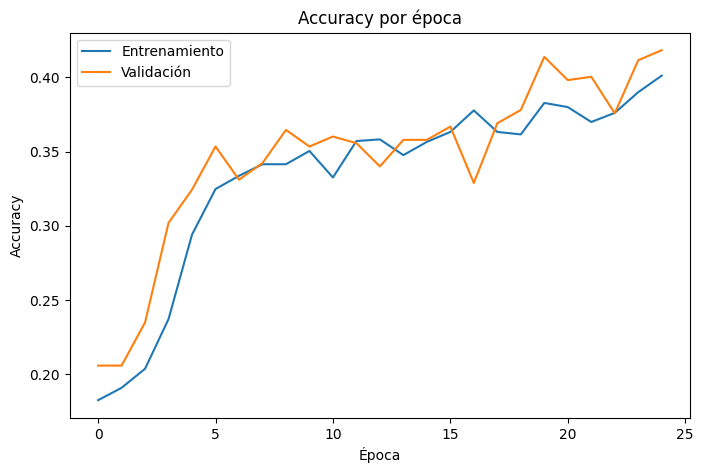

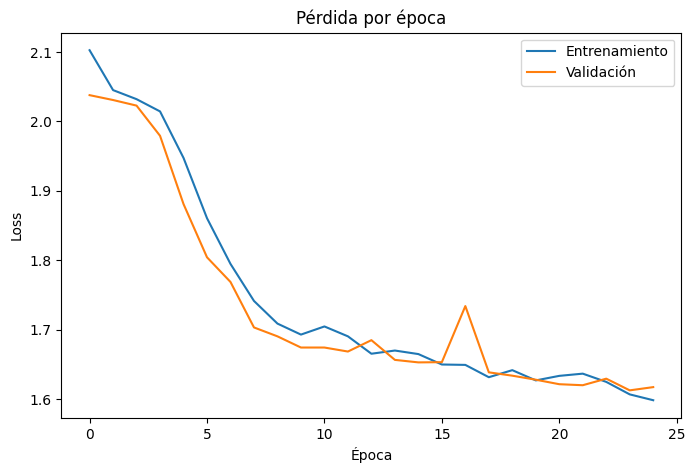

In [14]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()